In [130]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from random_projection import random_matrix_generator
from simulation import Simulation 

In [131]:
# Implementation of the geometric median from https://stackoverflow.com/questions/30299267/geometric-median-of-multidimensional-points/30299705#30299705
import numpy as np
from scipy.spatial.distance import cdist, euclidean
# a = np.array([[2., 3., 8.], [10., 4., 3.], [58., 3., 4.], [34., 2., 43.]])

def geometric_median(X, eps=1e-5):
    # Compute the geometric median for a list of vectors (rows of X) with the algorithm in http://www.pnas.org/content/pnas/97/4/1423.full.pdf
    y = np.mean(X, 0) 
    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y
        if euclidean(y, y1) < eps:
            return y1
        y = y1
def geometric_median_matrices(Xs, eps = 1e-5): 
    # For all X_i in Xs, we want to apply the geometric median to every row at the same position of the matrix
    result = np.zeros(Xs[0].shape)
    num_rows = Xs[0].shape[0]
    for i in range(num_rows):         
        # Stack the ith row of all matrices in X
        mat = np.stack([ Xs[j][i,:] for j in range(len(Xs))],0)
        result[i,:] = geometric_median(mat, eps = eps)
    return result

In [132]:
def dim_reduce(X, k, rm_typ, krao = False, vr = False, vr_num = 5, num_runs = 100, seed = 1): 
    # Reduce the size of X via random projection from the left with num_runs simulations 
    '''
    :param X: input matrix of size m x n 
    :param k: the reduced dimension
    :param rm_typ: type of the projection matrix
    :param krao: whether apply the Khatri-Rao map. Note, here for simplicity, I assume m = m_0*2 and the Khatri-Rao map becomes k by m_0 x k by m_0
    :param vr: Variance Reduction. Whether apply variance 
    :param vr_num: Number of variance reduction iteration. Averaged by computing the geometric median
    '''
    np.random.seed(seed)
    m, n = X.shape 
    if not vr: 
        vr_num = 1
    # list of the reduced matrices over the data runs
    reduced_mats = []
    for i in range(num_runs): 
        for i in range(vr_num): 
            reduced_matvrs = []
            if not krao: 
                # Reduced matrices at different iteration
                reduced_matvrs.append(random_matrix_generator(k, m, rm_typ)/np.sqrt(k))
            elif krao: 
                mat_kraos = []
                mat_kraos.append(random_matrix_generator(k,int(np.sqrt(m)),rm_typ).T)
                mat_kraos.append(random_matrix_generator(k,int(np.sqrt(m)),rm_typ).T)
                mat_krao = tl.tenalg.khatri_rao(mat_kraos).T/np.sqrt(k)
                reduced_matvrs.append(mat_krao)
        reduced_mat = mean(reduced_matvrs) 
        reduced_mats.append(reduced_mat)
    return(reduced_mats) 

In [137]:
def compute_relerr(reduced_mat, origin_mat): 
    k = reduced_mat.shape[0]
    return np.linalg.norm(reduced_mat)/np.linalg.norm(origin_mat)

In [138]:
def nips_sims(X, ks, num_runs = 100, seed = 1):  
    err_gs = []
    err_sp1s = []
    err_gprods = [] 
    err_gprod_vrs = [] 
    std_gs = []
    std_sp1s = []
    std_gprods = [] 
    std_gprod_vrs = [] 
    for k in ks:
        print(k)
        sim_g = dim_reduce(X, k, 'g', krao = False, vr = False, vr_num = 5, num_runs = 100, seed = 1)
        sim_sp1 = dim_reduce(X, k, 'sp1', krao = False, vr = False, vr_num = 5, num_runs = 100, seed = 1)
        sim_gprod = dim_reduce(X, k, 'g', krao = True, vr = False, vr_num = 5, num_runs = 100, seed = 1)
        sim_gprod_vr = dim_reduce(X, k, 'g', krao = True, vr = True, vr_num = 5, num_runs = 100, seed = 1)
        def update_err_std(X, errs, stds, sim): 
            err = np.asarray([compute_relerr(i, X) for i in sim]) 
            errs = np.append(errs,np.mean(err)) 
            stds = np.append(stds,np.std(err))
            return([errs, stds])
        [err_gs, std_gs] = update_err_std(X,err_gs, std_gs,sim_g)
        [err_sp1s, std_sp1s] = update_err_std(X,err_sp1s, std_sp1s,sim_sp1)
        [err_gprods, std_gprods] = update_err_std(X,err_gprods, std_gprods,sim_gprod)
        [err_gprod_vrs, std_gprod_vrs] = update_err_std(X,err_gprod_vrs, std_gprod_vrs,sim_gprod_vr)
    return [[err_gs, err_sp1s, err_gprods, err_gprod_vrs], [std_gs ,std_sp1s ,std_gprods,std_gprod_vrs]]



In [139]:
X = np.random.normal(0,1,(10000,10))
ks = np.arange(10, 60,10)
labels = ['Gaussian', 'Sparse Sign', 'Khatri-Rao', 'Khatri-Rao Variance Reduced'] 
name = ['g','sp1','gprod','gprod_vr']

In [140]:
results = nips_sims(X, ks)

10
20
30
40
50


In [141]:
def plot_nips_sims(ks, result, labels, name):
    plt.figure(figsize = (6,5))
    for i in np.arange(4):
        plt.errorbar(ks, results[0][i], 2*results[1][i],label = labels[i], capsize = 5) 
    plt.legend(loc = 'best')
    plt.xlabel('Reduced dimension')
    plt.ylabel('Relative Length after Transformation')
    plt.title(title)
#     plt.savefig('plots/'+name)
    plt.show()

NameError: name 'title' is not defined

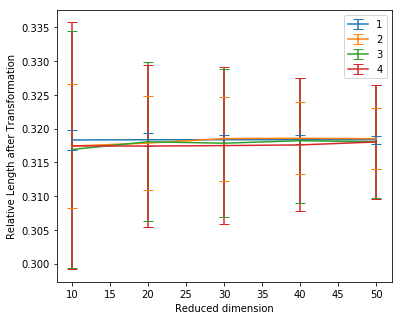

In [142]:
plot_nips_sims(ks, results, [1,2,3,4],[1,2,3,4])

In [ ]:
results